In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataframes of the different component
rooth_path = '../data/'
generator_train = pd.read_csv(rooth_path + 'generator_train.csv')
gen_bear_train = pd.read_csv(rooth_path + 'gen_bear_train.csv')
transformer_train = pd.read_csv(rooth_path + 'transformer_train.csv')
hydraulic_train = pd.read_csv(rooth_path + 'hydraulic_train.csv')
gearbox_train = pd.read_csv(rooth_path + 'gearbox_train.csv')
generator_test = pd.read_csv(rooth_path + 'generator_test.csv')
gen_bear_test = pd.read_csv(rooth_path + 'gen_bear_test.csv')
transformer_test = pd.read_csv(rooth_path + 'transformer_test.csv')
hydraulic_test = pd.read_csv(rooth_path + 'hydraulic_test.csv')
gearbox_test = pd.read_csv(rooth_path + 'gearbox_test.csv')

### We are ready to build our base-model for each component. 

- We will need to scale the features, within each turbine
- Since we have a very unbalanced dataset we will use SMOTE for balancing the training data set
- Reach a base line model
- Try other algorithms and fine tune
- Probably we will need to change the threshold to reduce the FP
- Calculate the different costs of our best models

In [3]:
# Scale within each turbine
def scale (df_train, df_test, scaler='StandardScaler'):
    
    '''Scale within each given turbine
    
    Args:
            df_train      : Train datarame
            df_test       : Test dataframe
        
    Returns:
            array         : Scaled array of train and test'''
    
    
    # Scale for turbine T01 first
    X_train1 = df_train.loc[df_train['Turbine_ID']=='T01']
    X_test1 = df_test.loc[df_test['Turbine_ID']=='T01']

    X_train1 = X_train1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    X_test1 = X_test1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    
    if scaler == 'MinMaxScaler':
        sc = MinMaxScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    else:
        sc = StandardScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    
    # Scale on other turbines
    turbines = ['T06', 'T07', 'T09', 'T11']
    for turbine in turbines:
        X_train_ = df_train.loc[df_train['Turbine_ID']==turbine]
        X_test_ = df_test.loc[df_test['Turbine_ID']==turbine]

        X_train_ = X_train_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
        X_test_ = X_test_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])

        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        else:
            sc = StandardScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        
        # Concatenate
        X_train1 = np.concatenate((X_train1, X_train_))
        X_test1 = np.concatenate((X_test1, X_test_))
        
             
    return X_train1, X_test1

In [4]:
# Data augmentation using SMOTE
def data_aug(X_train, y_train):
    
    '''Function for data augmentation, using SMOTE
    
    
    '''
    all_classes = Counter(y_train)
    majority_class = all_classes.most_common(1)
    minority_class = all_classes.most_common()[1:]
    ratio = minority_class[0][1]/majority_class[0][1]
    
    # If ratio of training set < 10% 
    if ratio < 0.1:
        over = SMOTE(sampling_strategy=0.1, random_state=0) # 10% of positive examples
        X_train, y_train = over.fit_sample(X_train, y_train)    
    
    return X_train, y_train

In [5]:
# Function to predict
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
    
    #Grid Search
    grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    
    #Predictions
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [6]:
# Function for metrics
def metrics(estimator, X_test, y_test, y_pred):
    
    # Classification Report
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print(confusion_matrix(y_test, y_pred))
        
    #Roc Curve
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Precision Recall curve
    precision, recall, treshold = precision_recall_curve(y_test, y_pred)
    
    plt.figure(figsize=(15,5))
    
    # Plot Roc
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label= f'{estimator} AUC = %0.2f'% roc_auc)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
    
    # Plot Decision Recall
    plt.subplot(1,2,2)
    plt.plot(treshold, precision[:-1], c ='r', label ='Precision')
    plt.plot(treshold, recall[:-1], c ='b', label ='Recall')
    plt.xlabel("Treshold")
    plt.ylabel("%")
    plt.grid()
    plt.legend()
    
    plt.show()

In [7]:
# Logistic Regression
def logreg(X_train, X_test, y_train, y_test):
    model = 'Logistic Regression'
    clf_logreg = LogisticRegression(random_state=42, max_iter=3000, n_jobs=-1)
    gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
    gs_score = 'roc_auc'

    clf_logreg, pred_logreg = bin_classify(model, clf_logreg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_logreg)
    
    metrics(clf_logreg, X_test, y_test, pred_logreg['y_pred'])
    
    return clf_logreg, pred_logreg

In [8]:
# Random Forest Classifier
def rfc(X_train, X_test, y_train, y_test):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'max_depth': [4, 5, 6, 7, 8, 10, 15, 20], 'criterion': ['gini', 'entropy']}
    gs_score = 'roc_auc'

    clf_rfc, pred_rfc = bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)
    
    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'])
    
    return clf_rfc, pred_rfc

In [9]:
# Gradient Boosting Classifier
def gbc(X_train, X_test, y_train, y_test):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.5, 0.6, 0.8, 1]}
    gs_score = 'roc_auc'

    clf_gbc, pred_gbc= bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'])
    
    return clf_gbc, pred_gbc

In [10]:
# K-Neighbors
def knn(X_train, X_test, y_train, y_test):
    model = 'KNN'
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    gs_params = {'n_neighbors': [5, 7, 10, 15]}
    gs_score = 'roc_auc'

    clf_knn, pred_knn= bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'])
    
    return clf_knn, pred_knn

In [11]:
# Ada Boost Classifier
def abc(X_train, X_test, y_train, y_test):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]}
    gs_score = 'roc_auc'

    clf_abc, pred_abc= bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'])
    
    return clf_abc, pred_abc

In [12]:
# SVC
def svc(X_train, X_test, y_train, y_test):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'gamma': ['auto', 'scale']}
    gs_score = 'roc_auc'

    clf_svc, pred_svc= bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'])
    
    return clf_svc, pred_svc

In [13]:
# Naive Bayes
def gnb(X_train, X_test, y_train, y_test):
    model = 'Gaussian NB'
    clf_gnb = GaussianNB()
    gs_params = {}
    gs_score = 'roc_auc'

    clf_gnb, pred_gnb= bin_classify(model, clf_gnb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gnb)

    metrics(clf_gnb, X_test, y_test, pred_gnb['y_pred'])
    
    return clf_gnb, pred_gnb

# 1st Analysis - Base Models

## GENERATOR

In [14]:
# By exploration, drop columns:
gen_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd',
                'Gen_Phase3_Temp_Avg', 'Gen_Phase3_Temp_Avg_av', 'Gen_Phase3_Temp_Avg_sd',
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Nac_Temp_Avg', 'Nac_Temp_Avg_av', 'Nac_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [15]:
# Drop columns
generator_train_ = generator_train.drop(columns = gen_col_drop)
generator_test_ = generator_test.drop(columns = gen_col_drop)

In [16]:
# Scale
X_train_gen, X_test_gen = scale(generator_train_, generator_test_)

In [17]:
# Define target and Data Augmentation on training data
y_train_gen = generator_train['Failure']
y_test_gen = generator_test['Failure']
X_train_gen, y_train_gen = data_aug(X_train_gen, y_train_gen)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.81      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.90      0.81      0.85      1220

[[988 173]
 [ 59   0]]


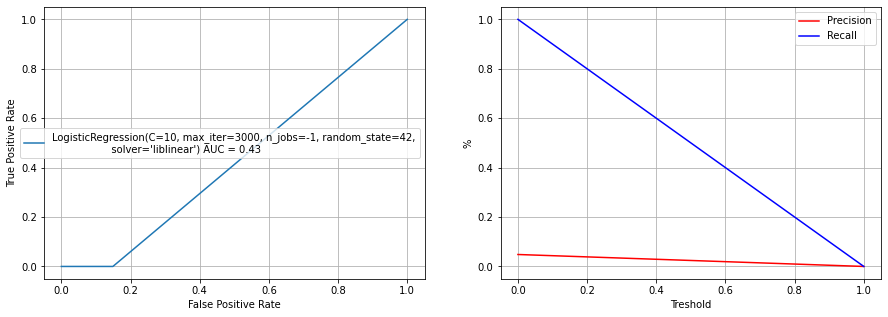


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.93      1220
   macro avg       0.48      0.49      0.48      1220
weighted avg       0.90      0.93      0.92      1220

[[1134   27]
 [  59    0]]


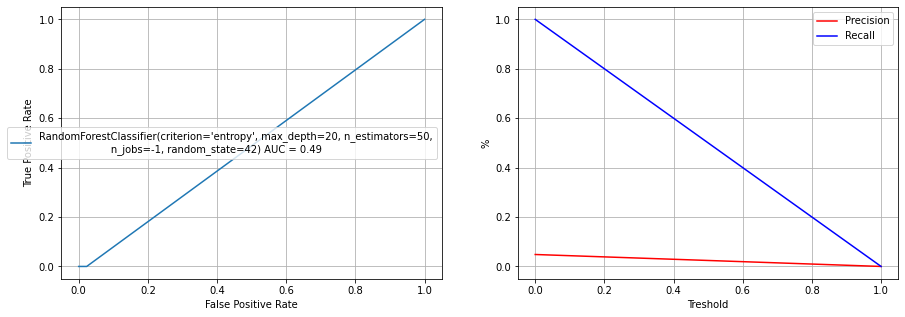


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.6, random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1161
           1       0.53      0.69      0.60        59

    accuracy                           0.96      1220
   macro avg       0.76      0.83      0.79      1220
weighted avg       0.96      0.96      0.96      1220

[[1125   36]
 [  18   41]]


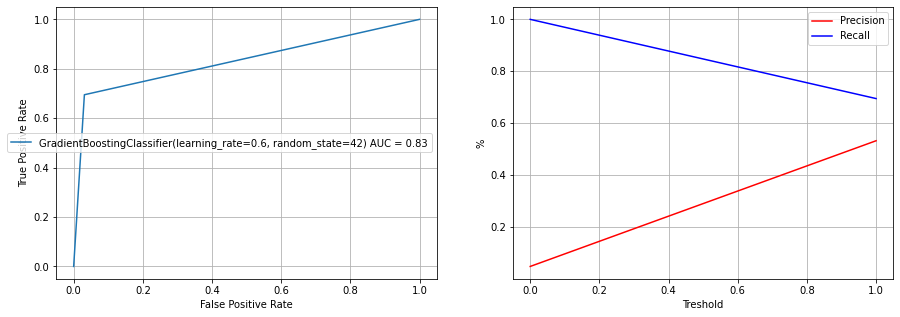


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.90      1220
   macro avg       0.47      0.47      0.47      1220
weighted avg       0.90      0.90      0.90      1220

[[1092   69]
 [  59    0]]


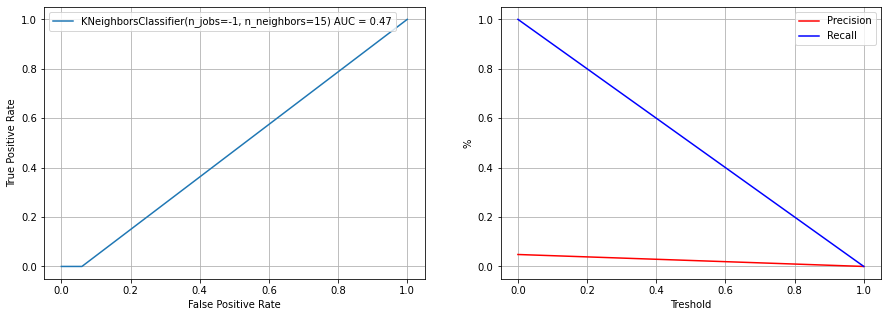


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.87      1220
   macro avg       0.47      0.46      0.47      1220
weighted avg       0.90      0.87      0.89      1220

[[1064   97]
 [  59    0]]


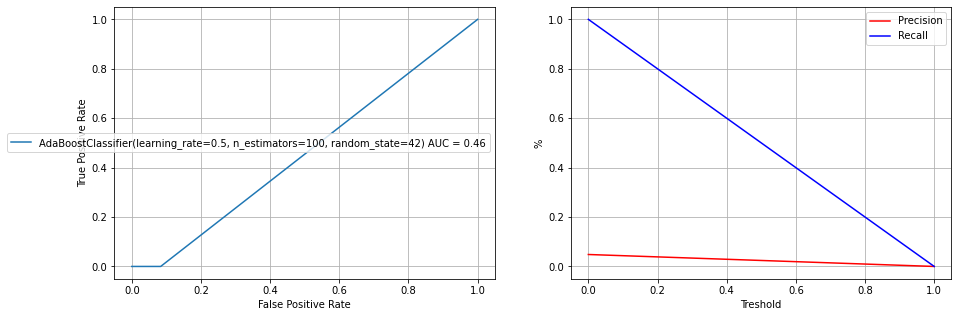


Best Parameters:
 SVC(C=1, degree=2, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.81      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.90      0.81      0.85      1220

[[992 169]
 [ 59   0]]


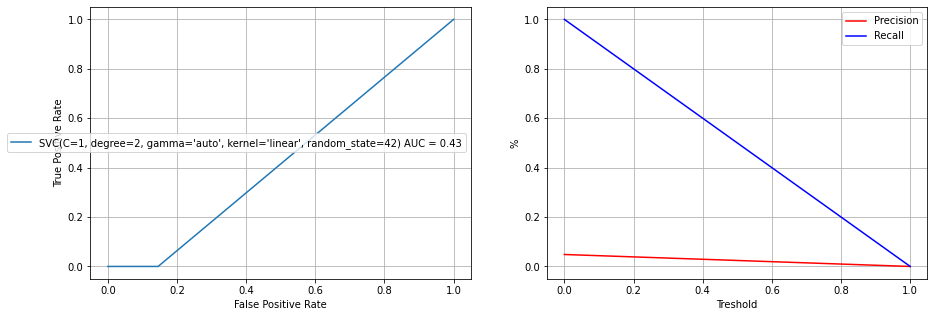


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.74      1220
   macro avg       0.47      0.39      0.42      1220
weighted avg       0.89      0.74      0.81      1220

[[898 263]
 [ 59   0]]


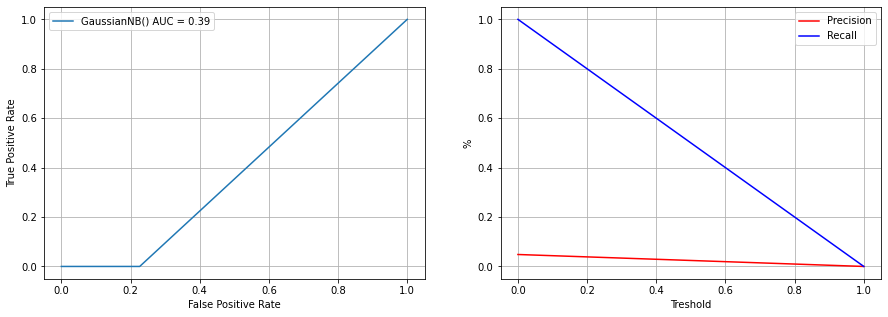

In [18]:
clf_logreg_gen, pred_logreg_gen = logreg(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_rfc_gen, pred_rfc_gen = rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gbc_gen, pred_gbc_gen = gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_knn_gen, pred_knn_gen = knn(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_abc_gen, pred_abc_gen = abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_svc_gen, pred_svc_gen = svc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gnb_gen, pred_gnb_gen = gnb(X_train_gen, X_test_gen, y_train_gen, y_test_gen)

## GENERATOR BEARING

In [19]:
# By exploration, drop columns:
bear_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd',
                'Gen_Phase3_Temp_Avg', 'Gen_Phase3_Temp_Avg_av', 'Gen_Phase3_Temp_Avg_sd',
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Nac_Temp_Avg', 'Nac_Temp_Avg_av', 'Nac_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [20]:
# Drop columns
gen_bear_train_ = gen_bear_train.drop(columns = bear_col_drop)
gen_bear_test_ = gen_bear_test.drop(columns = bear_col_drop)

In [21]:
# Scale
X_train_bear, X_test_bear = scale(gen_bear_train_, gen_bear_test_)

In [22]:
# Define target and Data Augmentation on training data
y_train_bear = gen_bear_train['Failure']
y_test_bear = gen_bear_test['Failure']
X_train_bear, y_train_bear = data_aug(X_train_bear, y_train_bear)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      1138
           1       0.01      0.06      0.02        82

    accuracy                           0.57      1220
   macro avg       0.46      0.34      0.37      1220
weighted avg       0.84      0.57      0.68      1220

[[696 442]
 [ 77   5]]


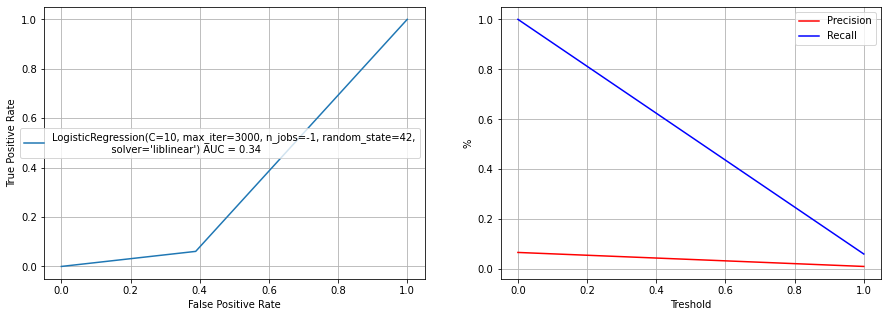


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=20,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1138
           1       0.22      0.02      0.04        82

    accuracy                           0.93      1220
   macro avg       0.58      0.51      0.50      1220
weighted avg       0.89      0.93      0.90      1220

[[1131    7]
 [  80    2]]


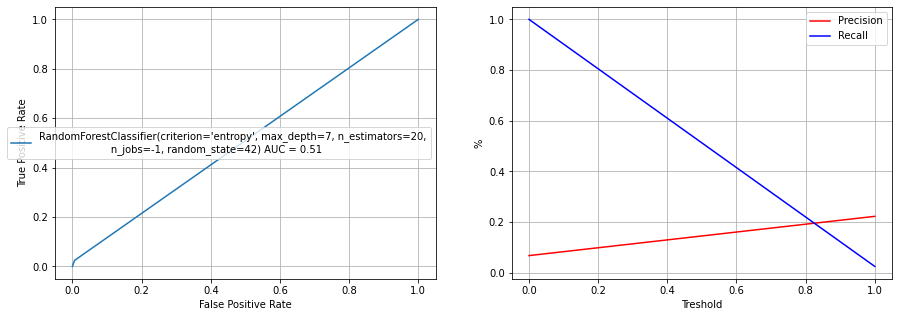


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1138
           1       0.08      0.22      0.11        82

    accuracy                           0.77      1220
   macro avg       0.51      0.51      0.49      1220
weighted avg       0.88      0.77      0.81      1220

[[917 221]
 [ 64  18]]


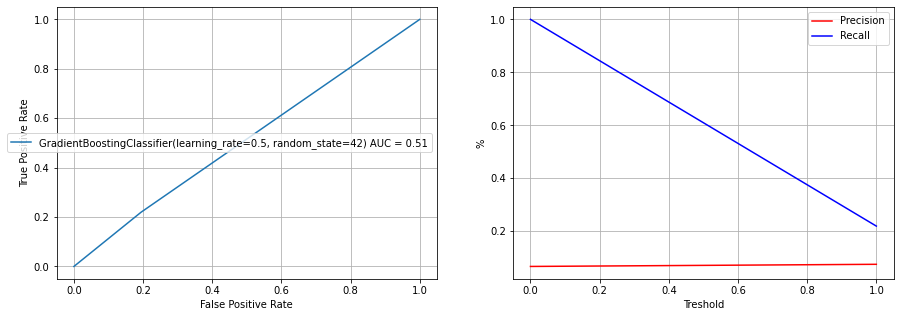


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1138
           1       0.09      0.05      0.06        82

    accuracy                           0.90      1220
   macro avg       0.51      0.51      0.50      1220
weighted avg       0.88      0.90      0.89      1220

[[1095   43]
 [  78    4]]


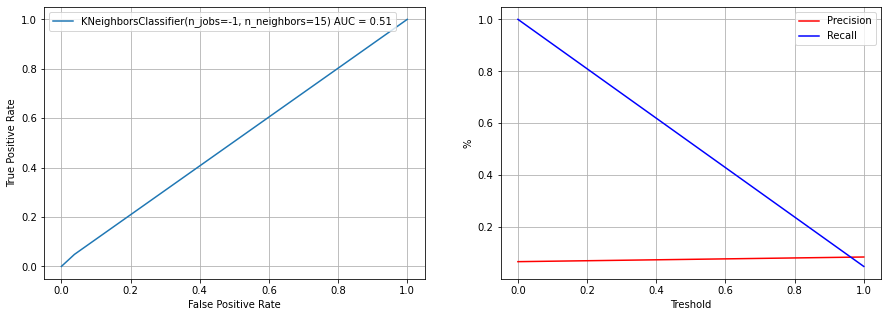


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=10, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1138
           1       0.09      0.23      0.13        82

    accuracy                           0.79      1220
   macro avg       0.51      0.53      0.51      1220
weighted avg       0.88      0.79      0.83      1220

[[948 190]
 [ 63  19]]


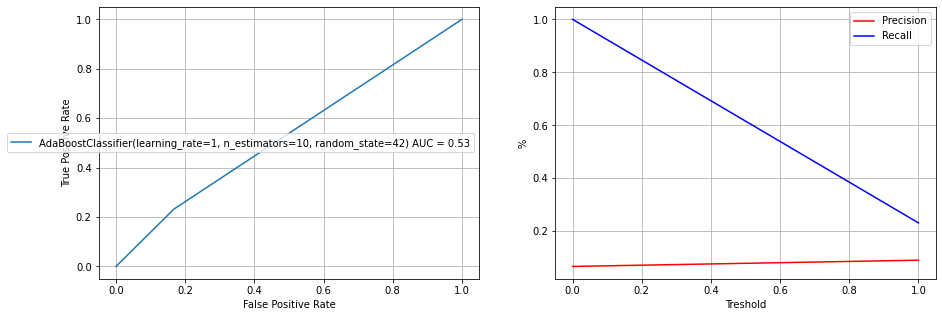


Best Parameters:
 SVC(C=0.1, degree=2, kernel='poly', random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


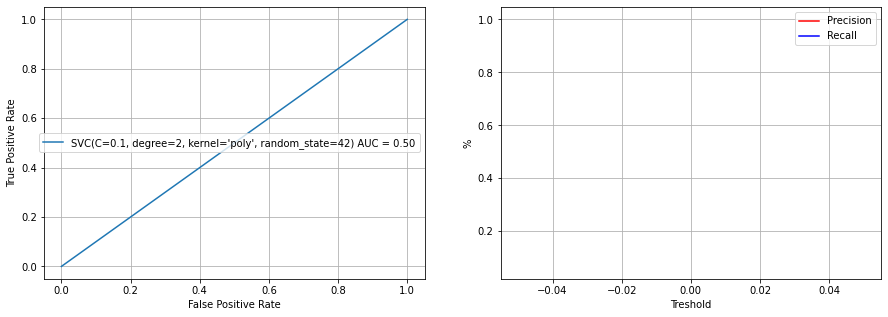


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.76      1220
   macro avg       0.46      0.41      0.43      1220
weighted avg       0.86      0.76      0.81      1220

[[929 209]
 [ 82   0]]


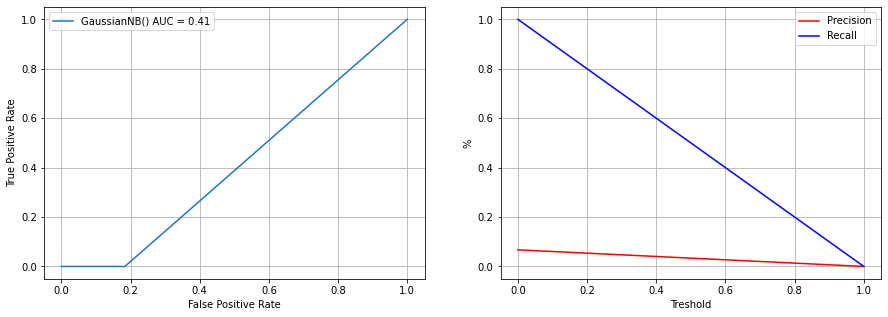

In [23]:
clf_logreg_bear, pred_logreg_bear = logreg(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_rfc_bear, pred_rfc_bear = rfc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gbc_bear, pred_gbc_bear = gbc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_knn_bear, pred_knn_bear = knn(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_abc_bear, pred_abc_bear = abc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_svc_bear, pred_svc_bear = svc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gnb_bear, pred_gnb_bear = gnb(X_train_bear, X_test_bear, y_train_bear, y_test_bear)

## TRANSFORMER

In [24]:
# By exploration, drop columns:
transf_col_drop = ['HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase2_Temp_Avg_sd',
                   'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd',
                   'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                   'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                   'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                   'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                   'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                   'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                   'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [25]:
# Drop columns
transformer_train_ = transformer_train.drop(columns = transf_col_drop)
transformer_test_ = transformer_test.drop(columns = transf_col_drop)

In [26]:
# Scale
X_train_transf, X_test_transf = scale(transformer_train_, transformer_test_)

In [27]:
# Define target and Data Augmentation on training data
y_train_transf = transformer_train['Failure']
y_test_transf = transformer_test['Failure']
X_train_transf, y_train_transf = data_aug(X_train_transf, y_train_transf)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1161
           1       0.10      0.32      0.15        59

    accuracy                           0.82      1220
   macro avg       0.53      0.59      0.53      1220
weighted avg       0.92      0.82      0.87      1220

[[987 174]
 [ 40  19]]


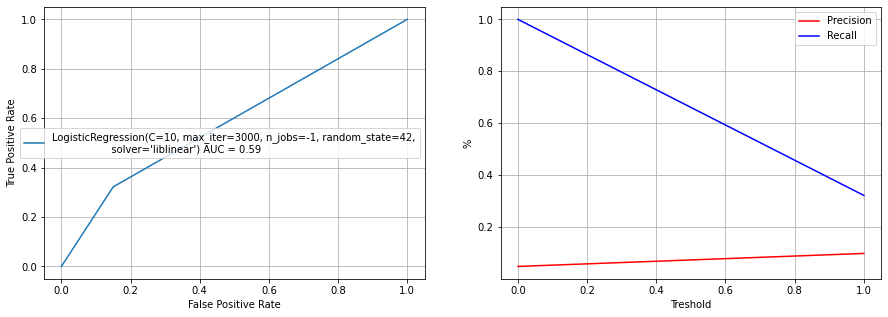


Best Parameters:
 RandomForestClassifier(max_depth=6, n_estimators=50, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1161
           1       0.03      0.02      0.02        59

    accuracy                           0.93      1220
   macro avg       0.49      0.50      0.49      1220
weighted avg       0.91      0.93      0.92      1220

[[1132   29]
 [  58    1]]


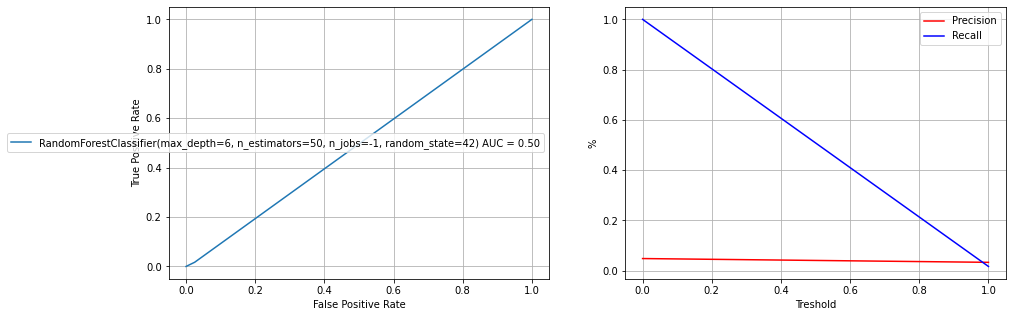


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1161
           1       0.01      0.05      0.02        59

    accuracy                           0.74      1220
   macro avg       0.48      0.41      0.43      1220
weighted avg       0.90      0.74      0.81      1220

[[897 264]
 [ 56   3]]


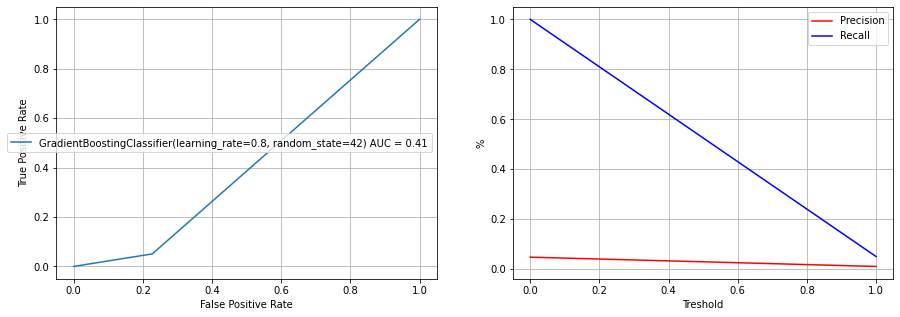


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1161
           1       0.02      0.02      0.02        59

    accuracy                           0.92      1220
   macro avg       0.49      0.49      0.49      1220
weighted avg       0.91      0.92      0.91      1220

[[1120   41]
 [  58    1]]


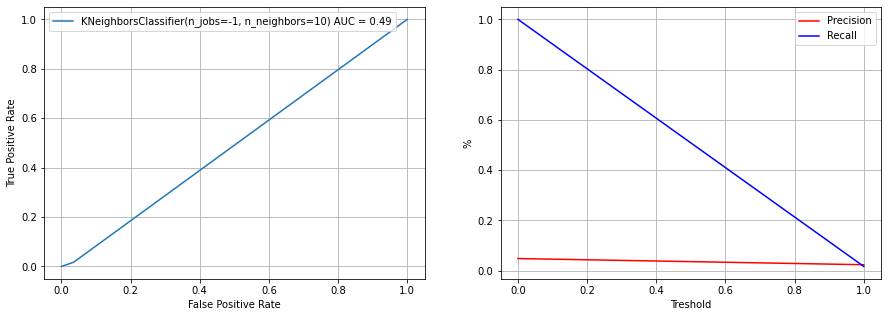


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1161
           1       0.04      0.14      0.06        59

    accuracy                           0.78      1220
   macro avg       0.49      0.47      0.47      1220
weighted avg       0.90      0.78      0.84      1220

[[945 216]
 [ 51   8]]


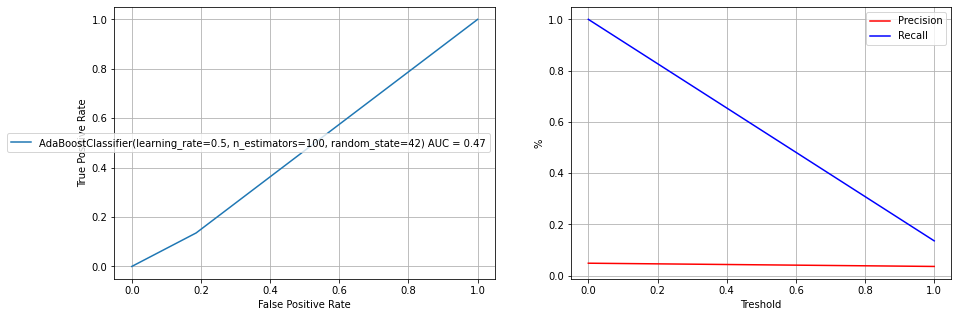


Best Parameters:
 SVC(C=1.2, degree=2, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


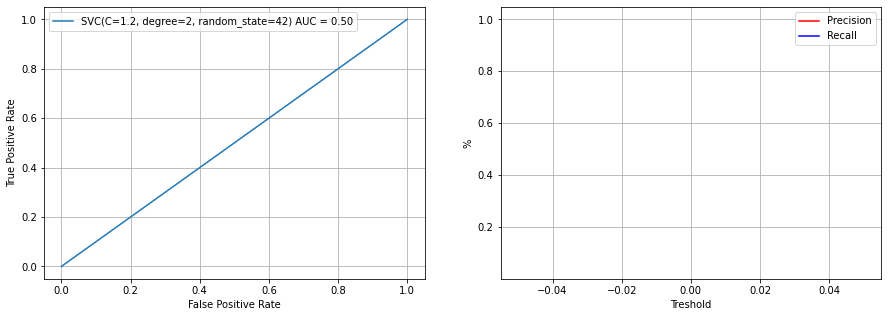


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1161
           1       0.14      0.85      0.24        59

    accuracy                           0.74      1220
   macro avg       0.56      0.79      0.54      1220
weighted avg       0.95      0.74      0.81      1220

[[850 311]
 [  9  50]]


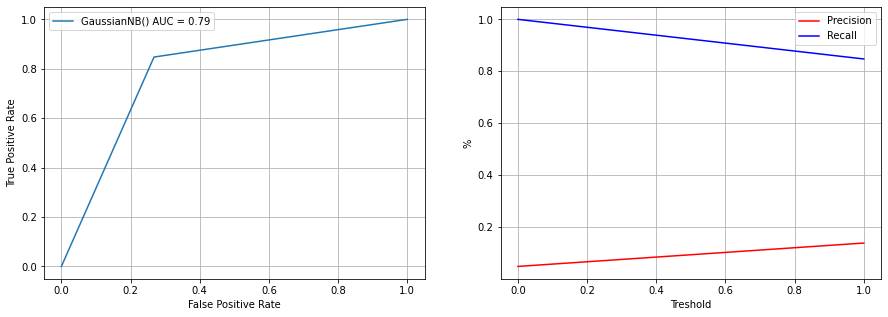

In [28]:
clf_logreg_transf, pred_logreg_transf = logreg(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_rfc_transf, pred_rfc_transf = rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gbc_transf, pred_gbc_transf = gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_knn_transf, pred_knn_transf = knn(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_abc_transf, pred_abc_transf = abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_svc_transf, pred_svc_transf = svc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gnb_transf, pred_gnb_transf = gnb(X_train_transf, X_test_transf, y_train_transf, y_test_transf)

## HYDRAULIC

In [29]:
# By exploration, drop columns:
hyd_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [30]:
# Drop columns
hydraulic_train_ = hydraulic_train.drop(columns = hyd_col_drop)
hydraulic_test_ = hydraulic_test.drop(columns = hyd_col_drop)

In [31]:
# Scale
X_train_hyd, X_test_hyd = scale(hydraulic_train_, hydraulic_test_)

In [32]:
# Define target and Data Augmentation on training data
y_train_hyd = hydraulic_train['Failure']
y_test_hyd = hydraulic_test['Failure']
X_train_hyd, y_train_hyd = data_aug(X_train_hyd, y_train_hyd)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1043
           1       0.24      0.20      0.22       177

    accuracy                           0.80      1220
   macro avg       0.56      0.55      0.55      1220
weighted avg       0.78      0.80      0.79      1220

[[935 108]
 [142  35]]


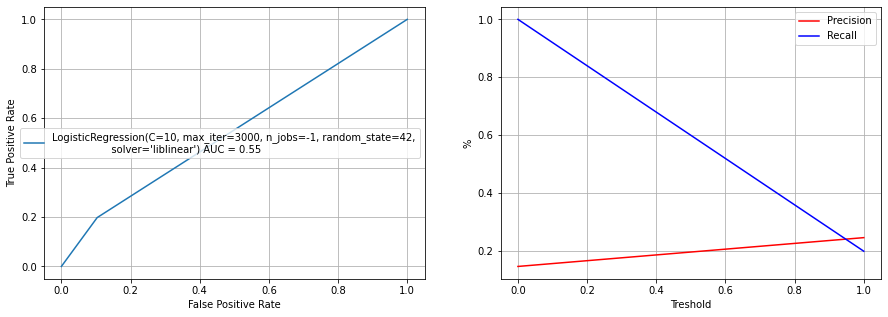


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=15, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.85      1220
   macro avg       0.43      0.50      0.46      1220
weighted avg       0.73      0.85      0.79      1220

[[1043    0]
 [ 177    0]]


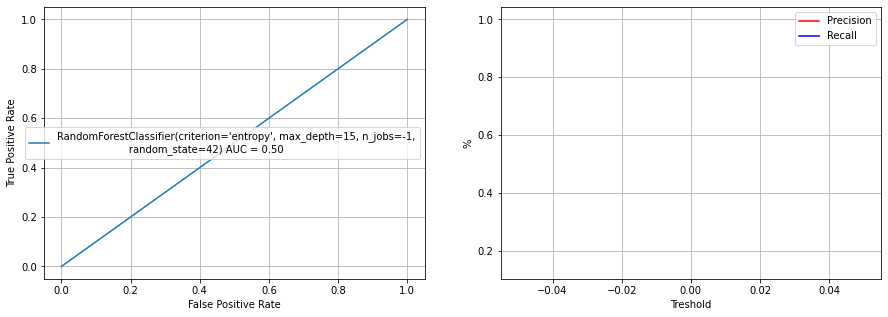


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1043
           1       0.42      0.12      0.19       177

    accuracy                           0.85      1220
   macro avg       0.65      0.55      0.55      1220
weighted avg       0.80      0.85      0.81      1220

[[1013   30]
 [ 155   22]]


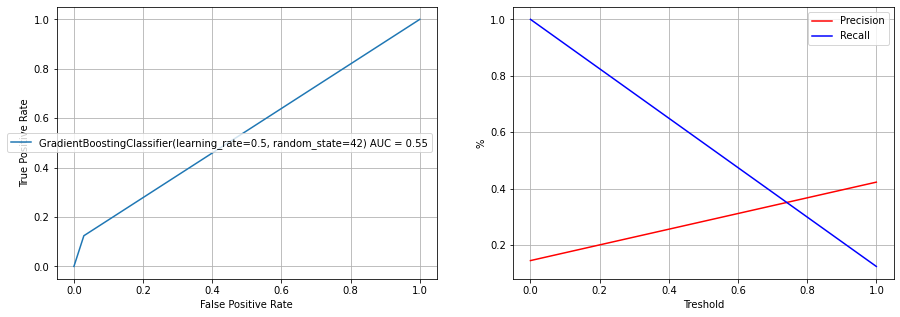


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1043
           1       0.14      0.15      0.14       177

    accuracy                           0.74      1220
   macro avg       0.49      0.49      0.49      1220
weighted avg       0.75      0.74      0.74      1220

[[872 171]
 [150  27]]


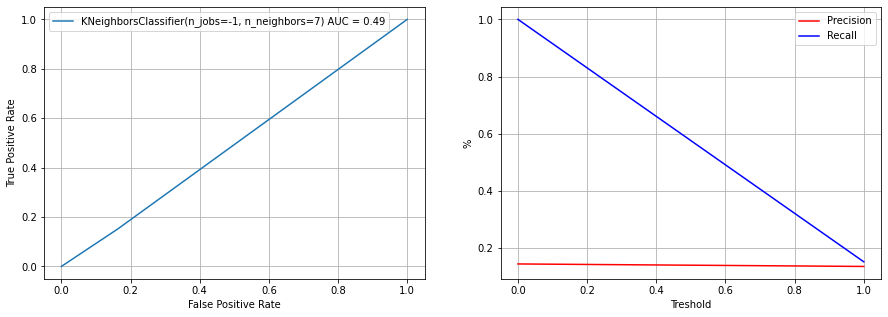


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1043
           1       0.17      0.05      0.07       177

    accuracy                           0.83      1220
   macro avg       0.51      0.50      0.49      1220
weighted avg       0.76      0.83      0.79      1220

[[1004   39]
 [ 169    8]]


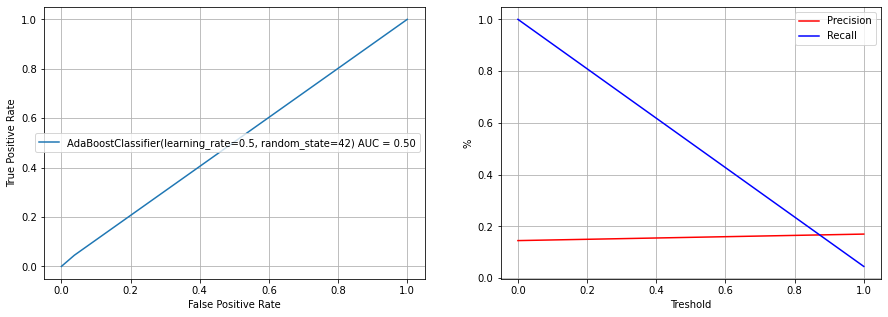


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1043
           1       0.22      0.20      0.21       177

    accuracy                           0.78      1220
   macro avg       0.54      0.54      0.54      1220
weighted avg       0.77      0.78      0.78      1220

[[914 129]
 [141  36]]


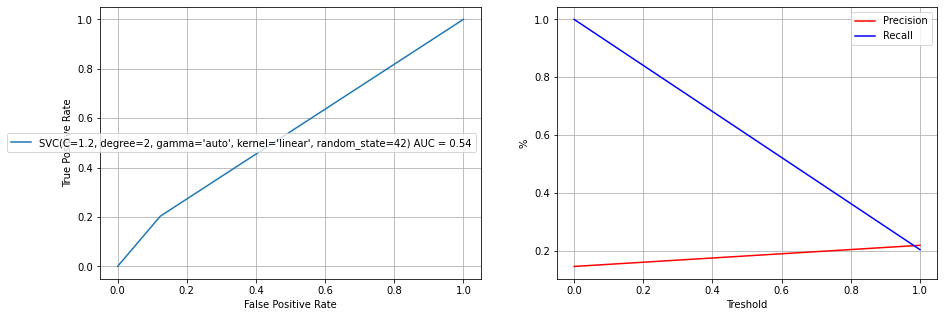


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1043
           1       0.28      0.37      0.32       177

    accuracy                           0.77      1220
   macro avg       0.58      0.60      0.59      1220
weighted avg       0.80      0.77      0.78      1220

[[878 165]
 [112  65]]


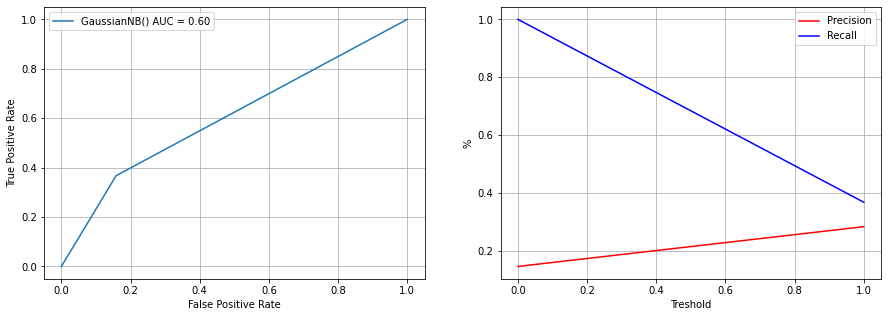

In [33]:
clf_logreg_hyd, pred_logreg_hyd = logreg(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_rfc_hyd, pred_rfc_hyd = rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gbc_hyd, pred_gbc_hyd = gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_knn_hyd, pred_knn_hyd = knn(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_abc_hyd, pred_abc_hyd = abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_svc_hyd, pred_svc_hyd = svc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gnb_hyd, pred_gnb_hyd = gnb(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)

## GEARBOX

In [34]:
# By exploration, drop columns:
gear_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [35]:
# Drop columns
gearbox_train_ = gearbox_train.drop(columns = gear_col_drop)
gearbox_test_ = gearbox_test.drop(columns = gear_col_drop)

In [36]:
# Scale
X_train_gear, X_test_gear = scale(gearbox_train_, gearbox_test_)

In [37]:
# Define target and Data Augmentation on training data
y_train_gear = gearbox_train['Failure']
y_test_gear = gearbox_test['Failure']
X_train_gear, y_train_gear = data_aug(X_train_gear, y_train_gear)


Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.87      1212
   macro avg       0.47      0.46      0.47      1212
weighted avg       0.90      0.87      0.89      1212

[[1056   97]
 [  59    0]]


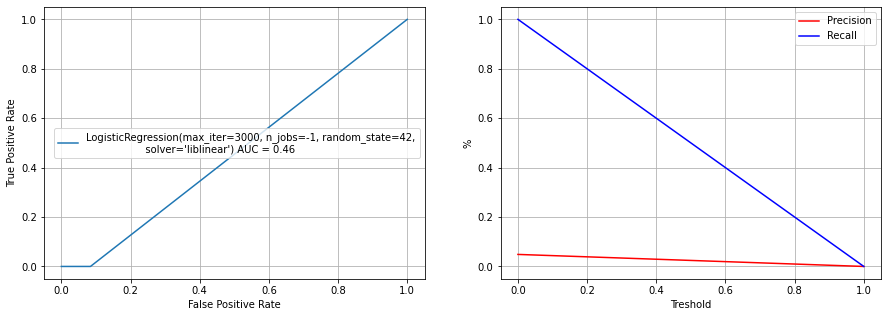


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


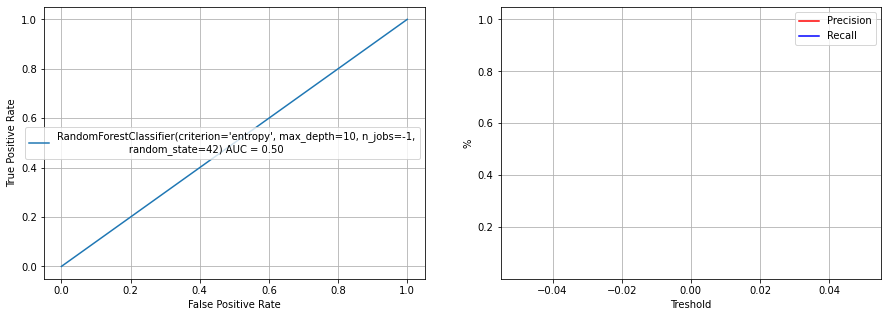


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.6, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1153
           1       0.10      0.20      0.13        59

    accuracy                           0.87      1212
   macro avg       0.53      0.55      0.53      1212
weighted avg       0.92      0.87      0.89      1212

[[1045  108]
 [  47   12]]


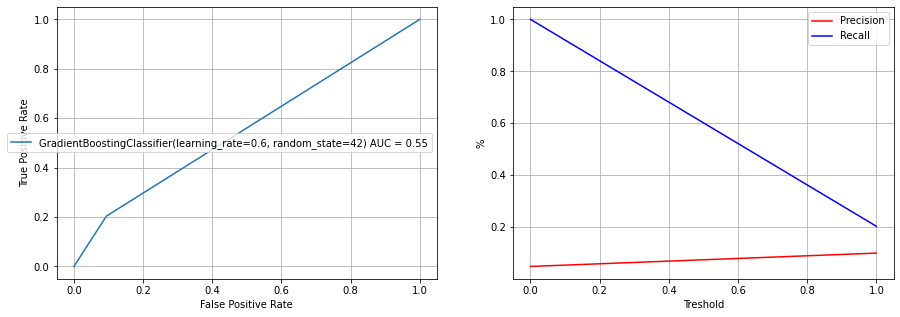


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1153
           1       0.21      0.27      0.24        59

    accuracy                           0.92      1212
   macro avg       0.59      0.61      0.60      1212
weighted avg       0.93      0.92      0.92      1212

[[1094   59]
 [  43   16]]


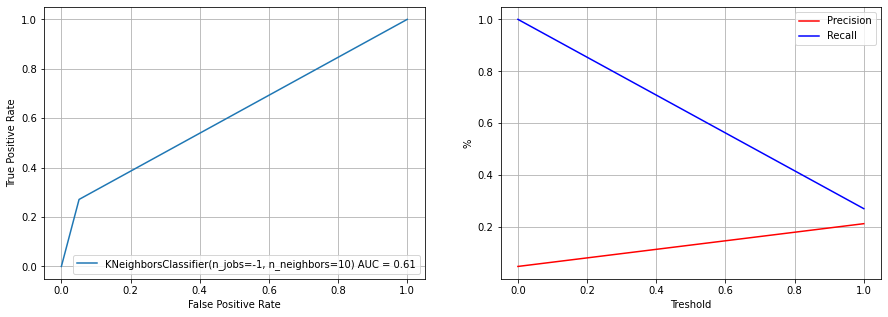


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.90      0.95      0.93      1212

[[1147    6]
 [  59    0]]


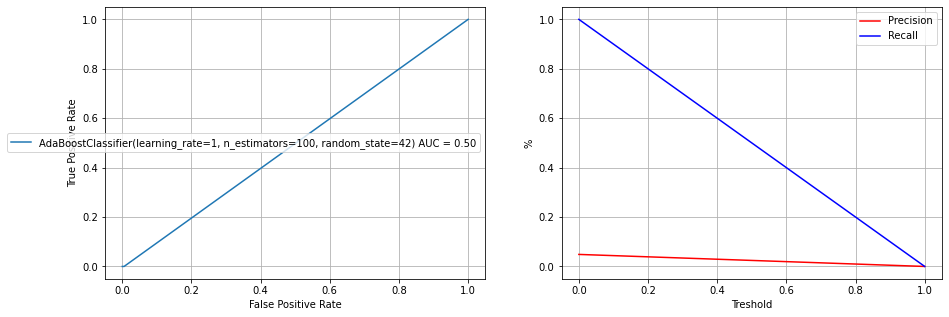


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1153
           1       0.07      0.05      0.06        59

    accuracy                           0.92      1212
   macro avg       0.51      0.51      0.51      1212
weighted avg       0.91      0.92      0.92      1212

[[1116   37]
 [  56    3]]


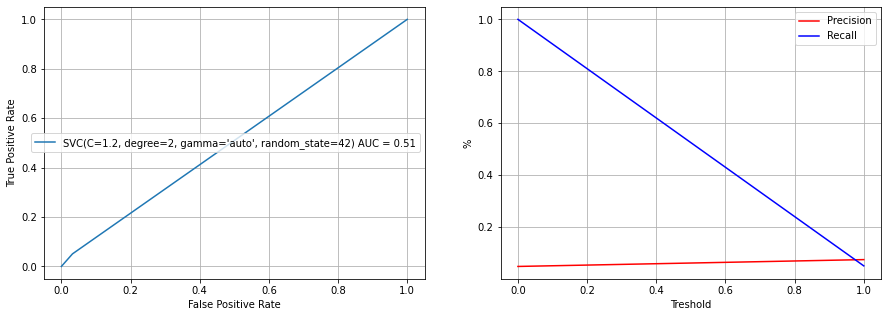


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.91      1212
   macro avg       0.47      0.48      0.48      1212
weighted avg       0.90      0.91      0.91      1212

[[1101   52]
 [  59    0]]


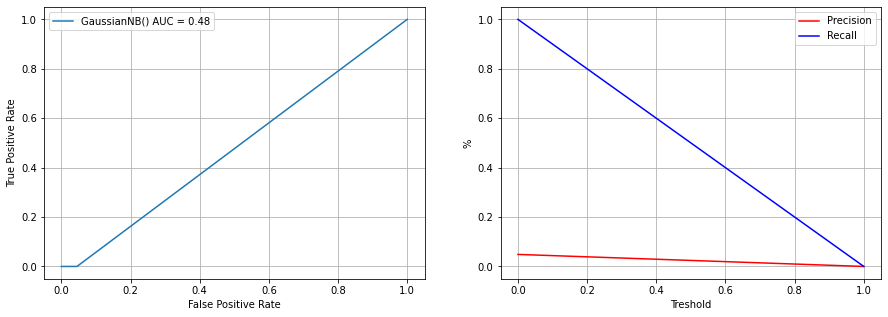

In [38]:
clf_logreg_gear, pred_logreg_gear = logreg(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_rfc_gear, pred_rfc_gear = rfc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gbc_gear, pred_gbc_gear = gbc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_knn_gear, pred_knn_gear = knn(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_abc_gear, pred_abc_gear = abc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_svc_gear, pred_svc_gear = svc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gnb_gear, pred_gnb_gear = gnb(X_train_gear, X_test_gear, y_train_gear, y_test_gear)

### Our models are not good

# 2nd Analysis - Try improvements

##### Let's see if we can improve our models just by choosing ONLY the input features for each component

## GENERATOR

In [39]:
generator_train_2 = generator_train[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                    'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                    'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                    'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                    'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd',
                                    'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                    'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]
generator_test_2 = generator_test[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                  'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                  'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                  'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                  'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd', 
                                  'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                  'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]

In [40]:
# Scale
X_train_gen_2, X_test_gen_2 = scale(generator_train_2, generator_test_2)

In [41]:
# Define target and Data Augmentation on training data
y_train_gen_2 = generator_train['Failure']
y_test_gen_2 = generator_test['Failure']
X_train_gen_2, y_train_gen_2 = data_aug(X_train_gen_2, y_train_gen_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.81      1220
   macro avg       0.47      0.43      0.45      1220
weighted avg       0.90      0.81      0.85      1220

[[988 173]
 [ 59   0]]


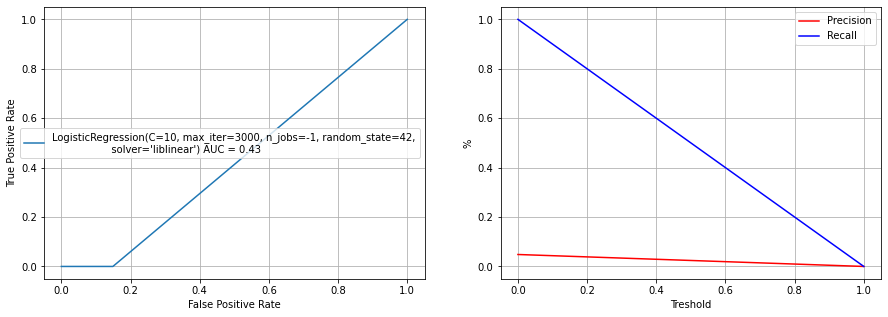


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1161
           1       0.89      0.56      0.69        59

    accuracy                           0.98      1220
   macro avg       0.93      0.78      0.84      1220
weighted avg       0.97      0.98      0.97      1220

[[1157    4]
 [  26   33]]


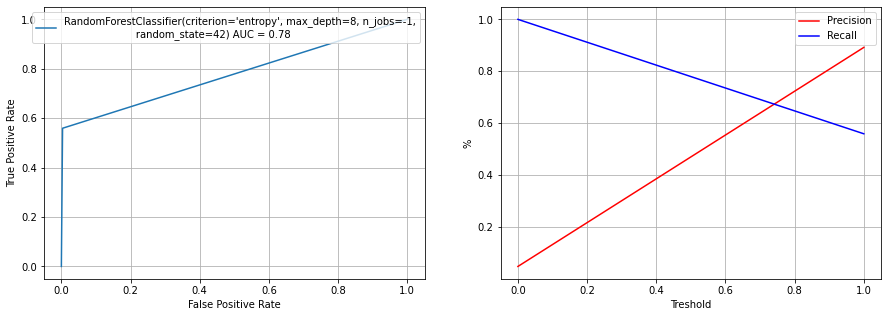


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1161
           1       0.95      0.61      0.74        59

    accuracy                           0.98      1220
   macro avg       0.96      0.80      0.87      1220
weighted avg       0.98      0.98      0.98      1220

[[1159    2]
 [  23   36]]


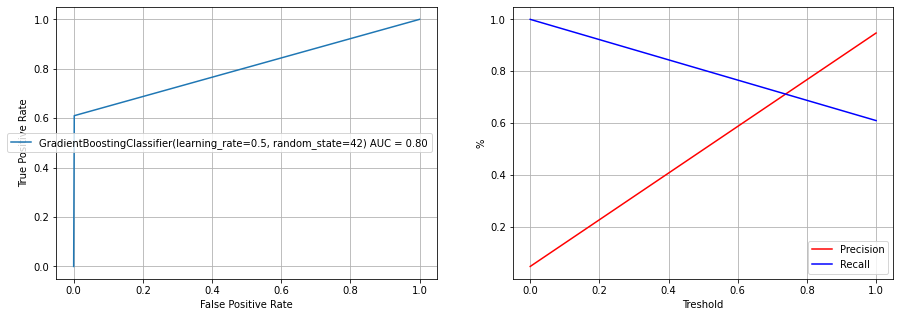


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.08      0.02      0.03        59

    accuracy                           0.94      1220
   macro avg       0.51      0.50      0.50      1220
weighted avg       0.91      0.94      0.92      1220

[[1149   12]
 [  58    1]]


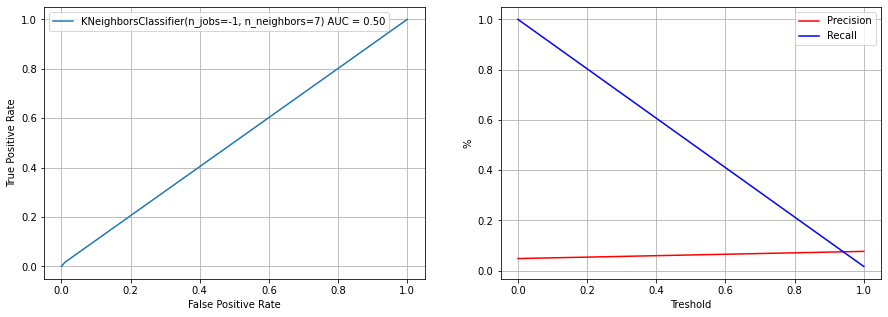


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=20, random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  59    0]]


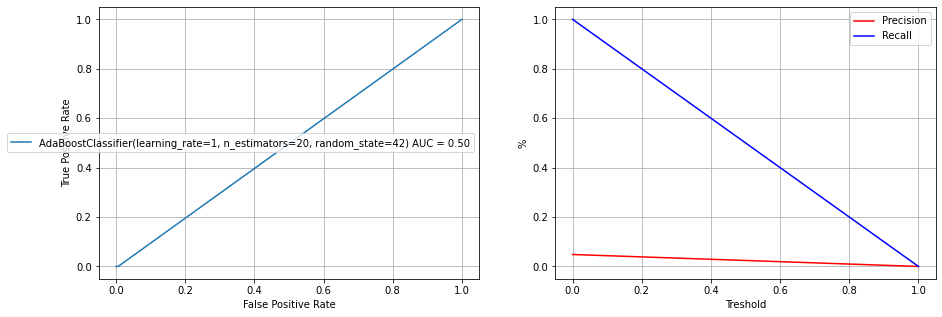


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='poly', random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  59    0]]


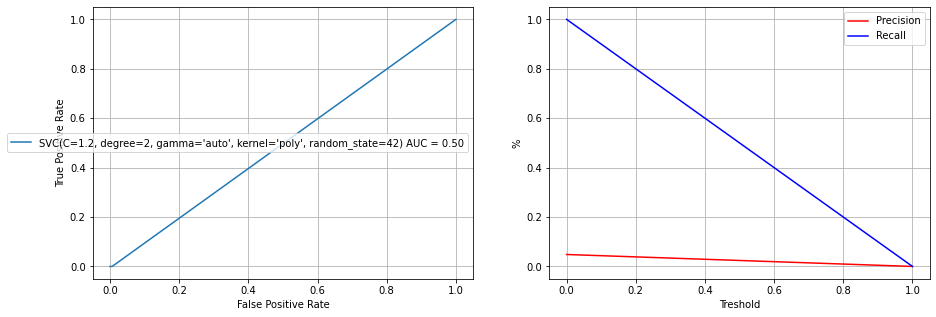


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1161
           1       0.13      0.64      0.21        59

    accuracy                           0.77      1220
   macro avg       0.55      0.71      0.54      1220
weighted avg       0.94      0.77      0.83      1220

[[899 262]
 [ 21  38]]


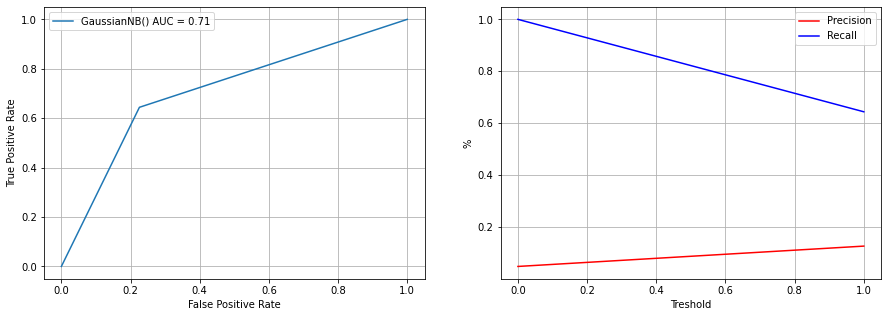

In [42]:
clf_logreg_gen_2, pred_logreg_gen_2 = logreg(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_rfc_gen_2, pred_rfc_gen_2 = rfc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gbc_gen_2, pred_gbc_gen_2 = gbc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_knn_gen_2, pred_knn_gen_2 = knn(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_abc_gen_2, pred_abc_gen_2 = abc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_svc_gen_2, pred_svc_gen_2 = svc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gnb_gen_2, pred_gnb_gen_2 = gnb(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)

## GENERATOR BEARING

In [43]:
gen_bear_train_2 = gen_bear_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd',
                                  'Gen_Bear2_Temp_Avg_sd']]
gen_bear_test_2 = gen_bear_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd', 
                                'Gen_Bear2_Temp_Avg_sd']]

In [44]:
# Scale
X_train_bear_2, X_test_bear_2 = scale(gen_bear_train_2, gen_bear_test_2)
# X_train_bear_2 = gen_bear_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_bear_2 = gen_bear_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [45]:
# Define target and Data Augmentation on training data
y_train_bear_2 = gen_bear_train['Failure']
y_test_bear_2 = gen_bear_test['Failure']
X_train_bear_2, y_train_bear_2 = data_aug(X_train_bear_2, y_train_bear_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1138
           1       0.07      0.09      0.08        82

    accuracy                           0.86      1220
   macro avg       0.50      0.50      0.50      1220
weighted avg       0.87      0.86      0.87      1220

[[1043   95]
 [  75    7]]


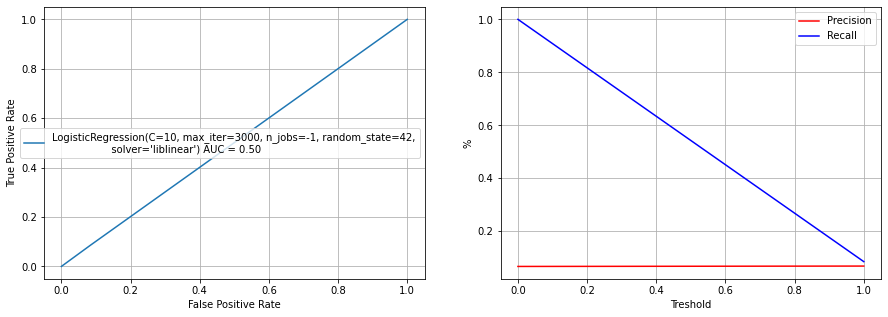


Best Parameters:
 RandomForestClassifier(max_depth=6, n_estimators=10, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1138
           1       0.03      0.05      0.04        82

    accuracy                           0.84      1220
   macro avg       0.48      0.47      0.48      1220
weighted avg       0.87      0.84      0.86      1220

[[1025  113]
 [  78    4]]


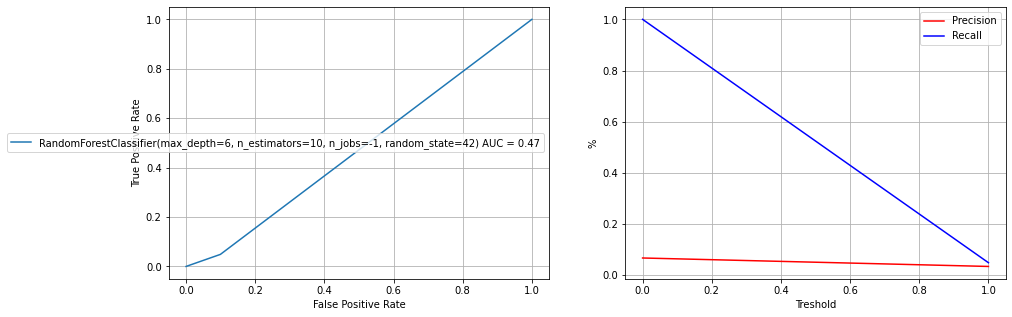


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=50, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1138
           1       0.04      0.07      0.05        82

    accuracy                           0.81      1220
   macro avg       0.48      0.47      0.47      1220
weighted avg       0.87      0.81      0.84      1220

[[985 153]
 [ 76   6]]


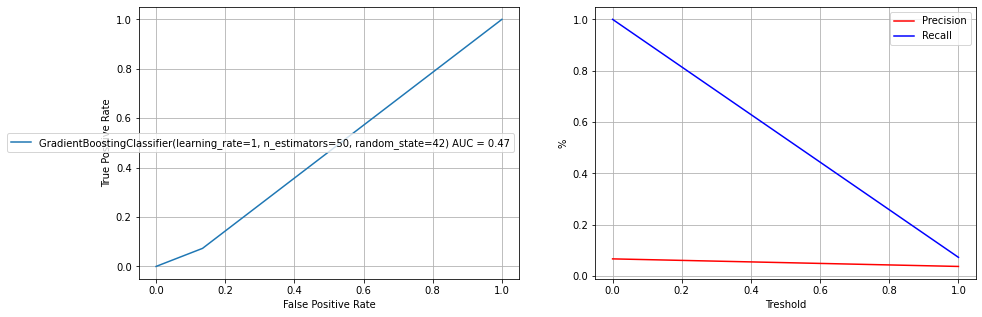


Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1138
           1       0.02      0.02      0.02        82

    accuracy                           0.84      1220
   macro avg       0.47      0.46      0.46      1220
weighted avg       0.87      0.84      0.85      1220

[[1017  121]
 [  80    2]]


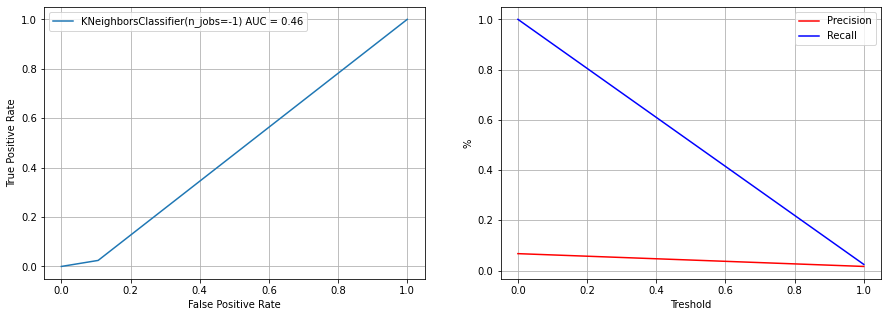


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.89      1220
   macro avg       0.46      0.48      0.47      1220
weighted avg       0.87      0.89      0.88      1220

[[1087   51]
 [  82    0]]


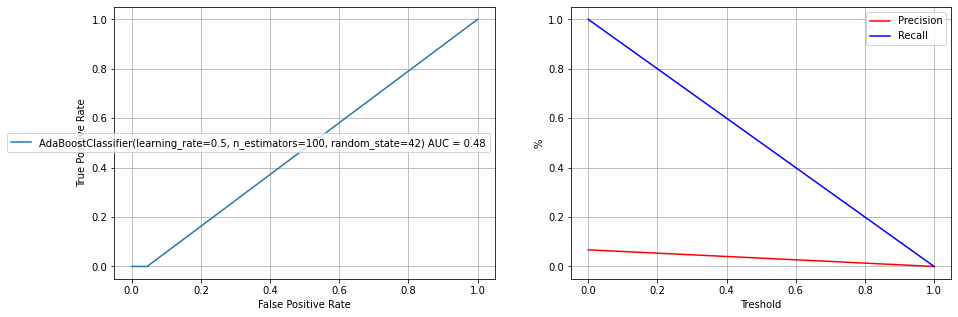


Best Parameters:
 SVC(C=0.01, degree=2, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


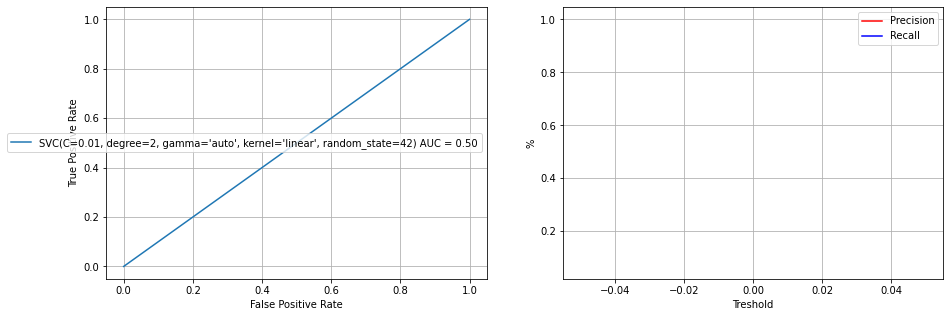


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1138
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1220
   macro avg       0.47      0.50      0.48      1220
weighted avg       0.87      0.93      0.90      1220

[[1138    0]
 [  82    0]]


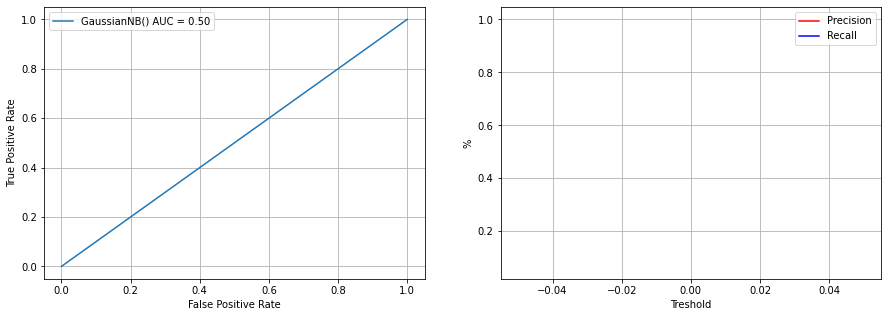

In [46]:
clf_logreg_bear_2, pred_logreg_bear_2 = logreg(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_rfc_bear_2, pred_rfc_bear_2 = rfc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gbc_bear_2, pred_gbc_bear_2 = gbc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_knn_bear_2, pred_knn_bear_2 = knn(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_abc_bear_2, pred_abc_bear_2 = abc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_svc_bear_2, pred_svc_bear_2 = svc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gnb_bear_2, pred_gnb_bear_2 = gnb(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)

## TRANSFORMER

In [47]:
transformer_train_2 = transformer_train[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 
                                        'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av',
                                        'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                                        'HVTrafo_Phase2_Temp_Avg_sd', 'HVTrafo_Phase3_Temp_Avg_sd']]
transformer_test_2 = transformer_test[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg',
                                      'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av', 'HVTrafo_Phase2_Temp_Avg_av', 
                                      'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 'HVTrafo_Phase2_Temp_Avg_sd', 
                                      'HVTrafo_Phase3_Temp_Avg_sd']]

In [48]:
# Scale
#X_train_transf_2, X_test_transf_2 = scale(transformer_train_2, transformer_test_2)
X_train_transf_2 = transformer_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
X_test_transf_2 = transformer_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [49]:
# Define target and Data Augmentation on training data
y_train_transf_2 = transformer_train['Failure']
y_test_transf_2 = transformer_test['Failure']
X_train_transf_2, y_train_transf_2 = data_aug(X_train_transf_2, y_train_transf_2)


Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


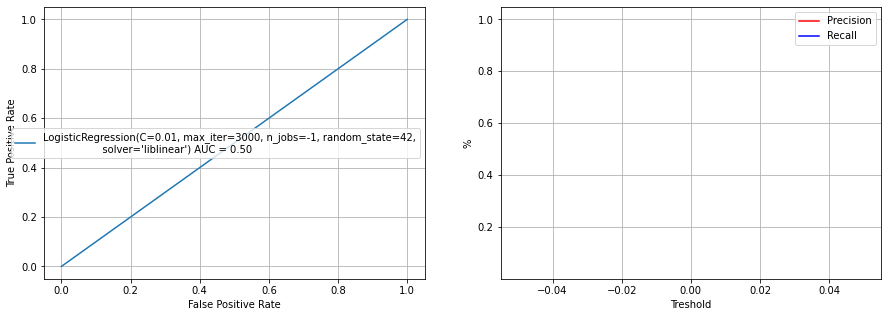


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1156    5]
 [  59    0]]


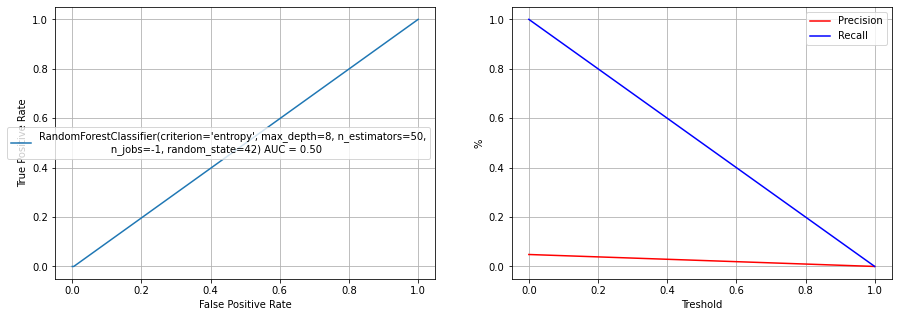


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1161
           1       0.24      0.10      0.14        59

    accuracy                           0.94      1220
   macro avg       0.60      0.54      0.56      1220
weighted avg       0.92      0.94      0.93      1220

[[1142   19]
 [  53    6]]


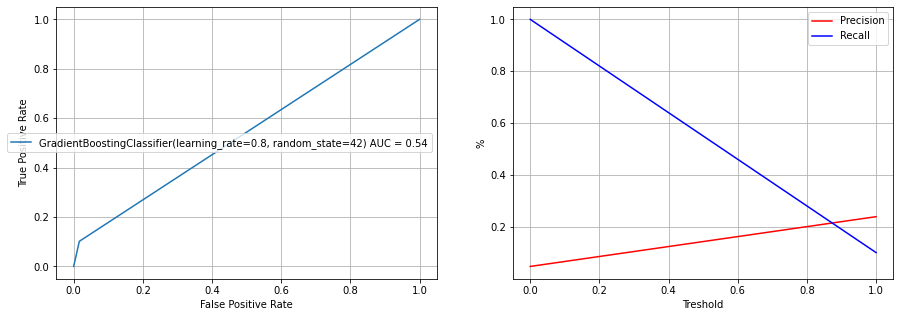


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.50      0.07      0.12        59

    accuracy                           0.95      1220
   macro avg       0.73      0.53      0.55      1220
weighted avg       0.93      0.95      0.93      1220

[[1157    4]
 [  55    4]]


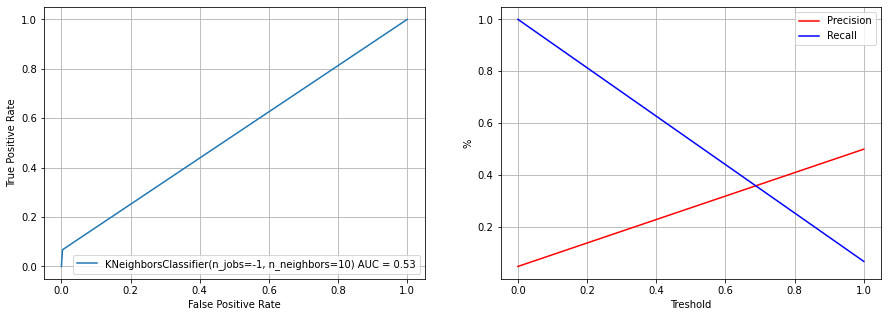


Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1161
           1       0.30      0.24      0.26        59

    accuracy                           0.94      1220
   macro avg       0.63      0.60      0.62      1220
weighted avg       0.93      0.94      0.93      1220

[[1128   33]
 [  45   14]]


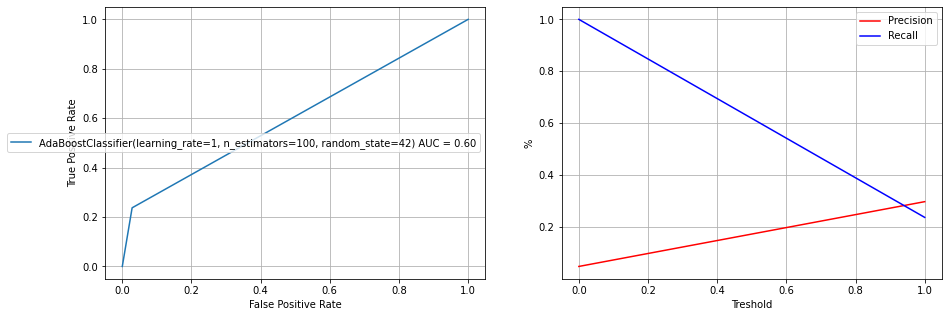


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


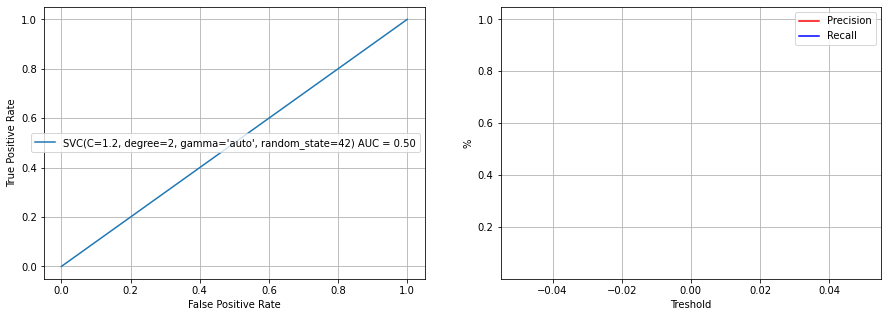


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1161
           1       0.12      0.02      0.03        59

    accuracy                           0.95      1220
   macro avg       0.54      0.51      0.50      1220
weighted avg       0.91      0.95      0.93      1220

[[1154    7]
 [  58    1]]


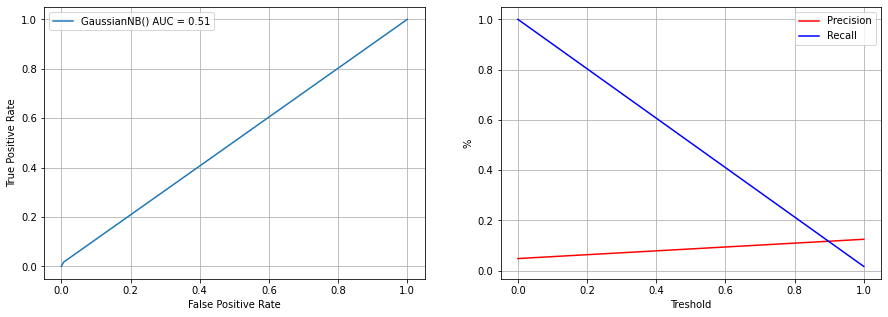

In [50]:
clf_logreg_transf_2, pred_logreg_transf_2 = logreg(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_rfc_transf_2, pred_rfc_transf_2 = rfc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gbc_transf_2, pred_gbc_transf_2 = gbc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_knn_transf_2, pred_knn_transf_2 = knn(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_abc_transf_2, pred_abc_transf_2 = abc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_svc_transf_2, pred_svc_transf_2 = svc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gnb_transf_2, pred_gnb_transf_2 = gnb(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)

## HYDRAULIC

In [51]:
hydraulic_train_2 = hydraulic_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                      'Hyd_Oil_Temp_Avg_sd']]
hydraulic_test_2 = hydraulic_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                      'Hyd_Oil_Temp_Avg_sd']]

In [52]:
# Scale
X_train_hyd_2, X_test_hyd_2 = scale(hydraulic_train_2, hydraulic_test_2)
# X_train_hyd_2 = hydraulic_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_hyd_2 = hydraulic_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [53]:
# Define target and Data Augmentation on training data
y_train_hyd_2 = hydraulic_train['Failure']
y_test_hyd_2 = hydraulic_test['Failure']
X_train_hyd_2, y_train_hyd_2 = data_aug(X_train_hyd_2, y_train_hyd_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1043
           1       0.05      0.02      0.03       177

    accuracy                           0.80      1220
   macro avg       0.45      0.48      0.46      1220
weighted avg       0.73      0.80      0.76      1220

[[968  75]
 [173   4]]


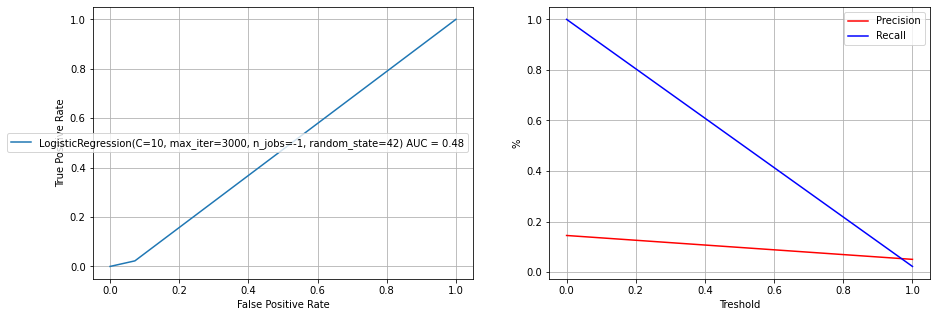


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=20, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1043
           1       0.06      0.01      0.02       177

    accuracy                           0.83      1220
   macro avg       0.46      0.49      0.46      1220
weighted avg       0.74      0.83      0.78      1220

[[1011   32]
 [ 175    2]]


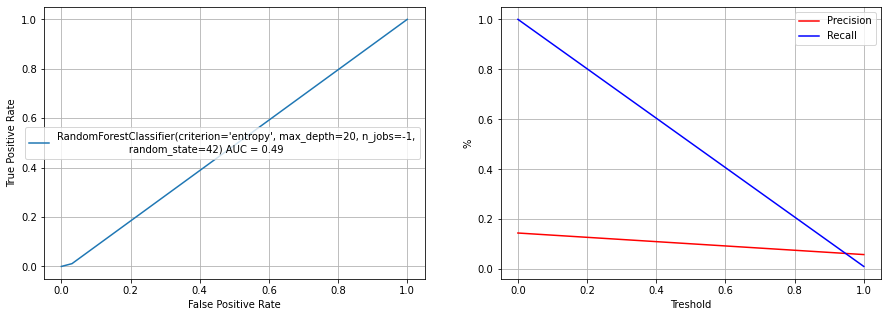


Best Parameters:
 GradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1043
           1       0.05      0.01      0.02       177

    accuracy                           0.82      1220
   macro avg       0.45      0.49      0.46      1220
weighted avg       0.74      0.82      0.78      1220

[[1004   39]
 [ 175    2]]


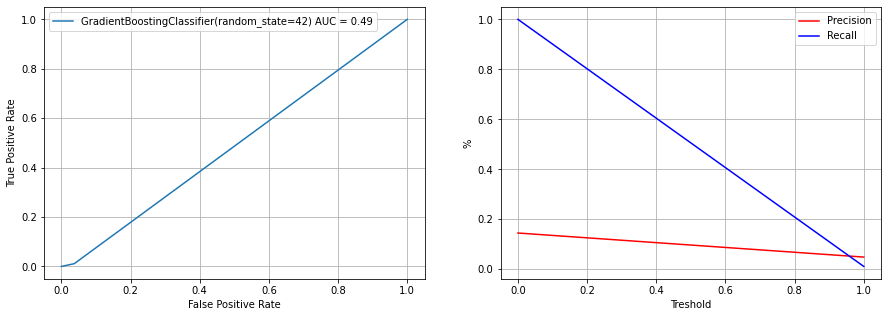


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=15)
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1043
           1       0.03      0.01      0.01       177

    accuracy                           0.83      1220
   macro avg       0.44      0.49      0.46      1220
weighted avg       0.73      0.83      0.78      1220

[[1013   30]
 [ 176    1]]


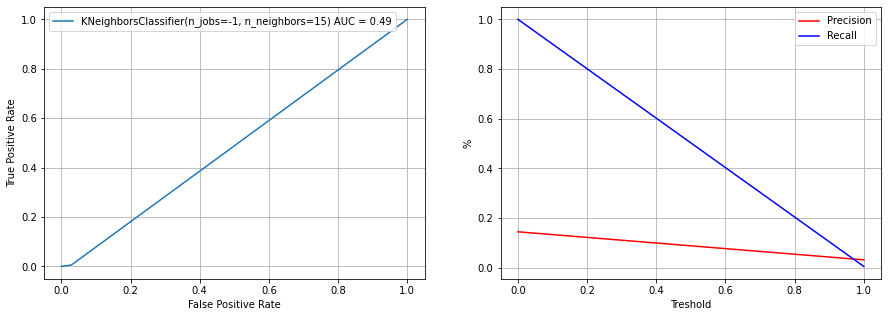


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.84      1220
   macro avg       0.43      0.49      0.46      1220
weighted avg       0.73      0.84      0.78      1220

[[1022   21]
 [ 177    0]]


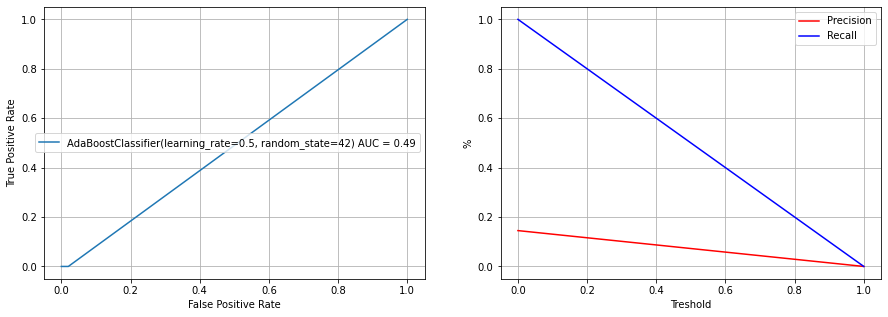


Best Parameters:
 SVC(C=1.2, degree=2, random_state=42)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.84      1220
   macro avg       0.43      0.49      0.46      1220
weighted avg       0.73      0.84      0.78      1220

[[1025   18]
 [ 177    0]]


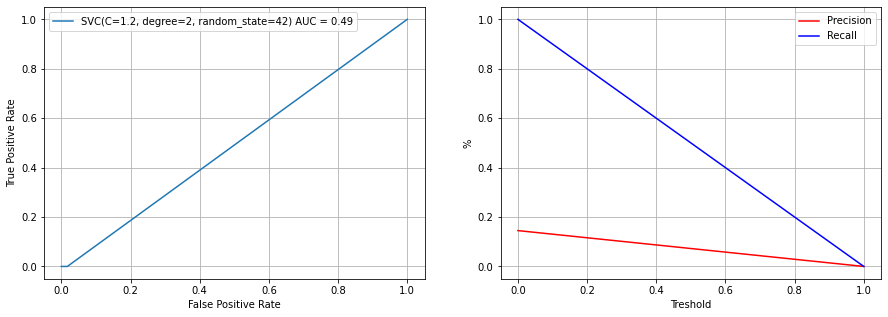


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.85      1220
   macro avg       0.43      0.50      0.46      1220
weighted avg       0.73      0.85      0.79      1220

[[1041    2]
 [ 177    0]]


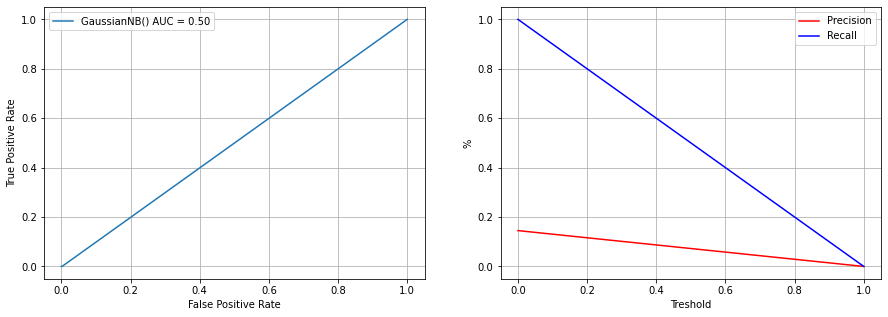

In [54]:
clf_logreg_hyd_2, pred_logreg_hyd_2 = logreg(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_rfc_hyd_2, pred_rfc_hyd_2 = rfc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gbc_hyd_2, pred_gbc_hyd_2 = gbc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_knn_hyd_2, pred_knn_hyd_2 = knn(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_abc_hyd_2, pred_abc_hyd_2 = abc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_svc_hyd_2, pred_svc_hyd_2 = svc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gnb_hyd_2, pred_gnb_hyd_2 = gnb(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)

## GEARBOX

In [55]:
gearbox_train_2 = gearbox_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]
gearbox_test_2 = gearbox_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]

In [56]:
# Scale
X_train_gear_2, X_test_gear_2 = scale(gearbox_train_2, gearbox_test_2)
# X_train_gear_2 = gearbox_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_gear_2 = gearbox_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [57]:
# Define target and Data Augmentation on training data
y_train_gear_2 = gearbox_train['Failure']
y_test_gear_2 = gearbox_test['Failure']
X_train_gear_2, y_train_gear_2 = data_aug(X_train_gear_2, y_train_gear_2)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


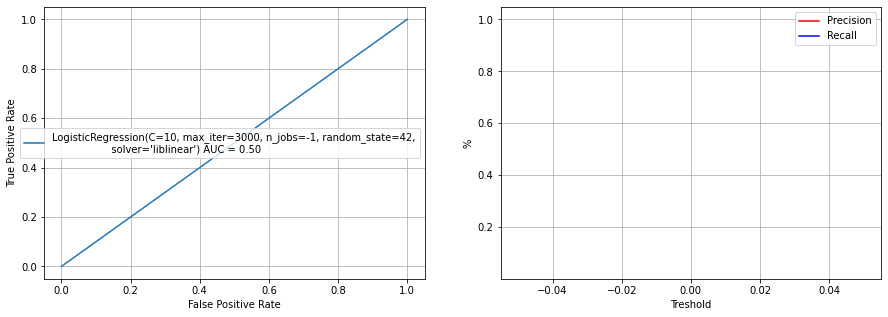


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=15, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.91      1212
   macro avg       0.47      0.48      0.48      1212
weighted avg       0.90      0.91      0.91      1212

[[1103   50]
 [  59    0]]


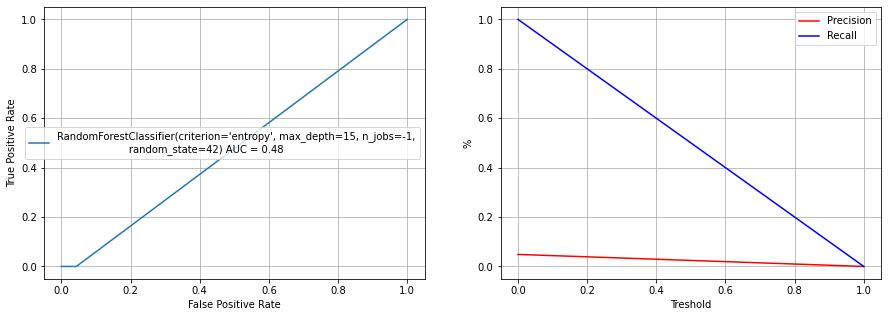


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1153
           1       0.10      0.17      0.12        59

    accuracy                           0.88      1212
   macro avg       0.53      0.54      0.53      1212
weighted avg       0.91      0.88      0.90      1212

[[1058   95]
 [  49   10]]


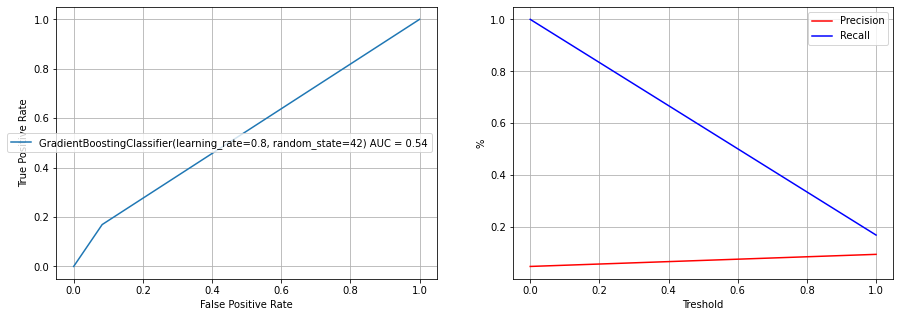


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1153
           1       0.13      0.15      0.14        59

    accuracy                           0.91      1212
   macro avg       0.54      0.55      0.54      1212
weighted avg       0.92      0.91      0.91      1212

[[1091   62]
 [  50    9]]


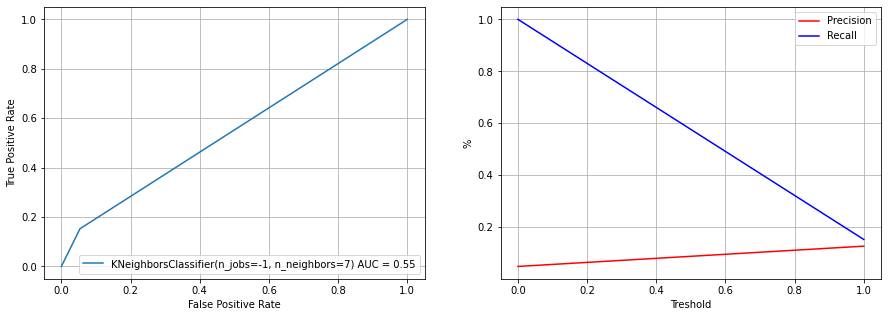


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1153
           1       0.13      0.15      0.14        59

    accuracy                           0.91      1212
   macro avg       0.55      0.55      0.55      1212
weighted avg       0.92      0.91      0.91      1212

[[1095   58]
 [  50    9]]


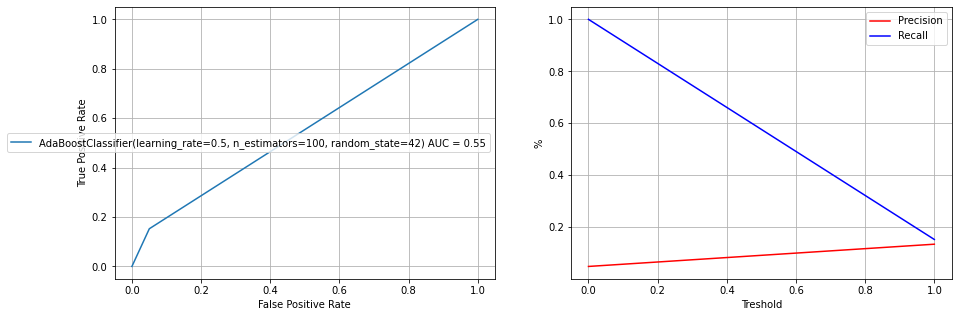


Best Parameters:
 SVC(C=1.2, degree=2, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1153
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1212
   macro avg       0.48      0.50      0.49      1212
weighted avg       0.91      0.95      0.93      1212

[[1153    0]
 [  59    0]]


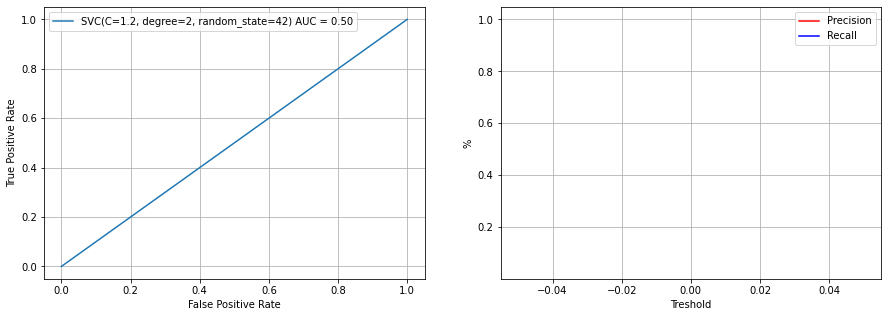


Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      1153
           1       0.09      0.39      0.14        59

    accuracy                           0.77      1212
   macro avg       0.52      0.59      0.50      1212
weighted avg       0.92      0.77      0.83      1212

[[906 247]
 [ 36  23]]


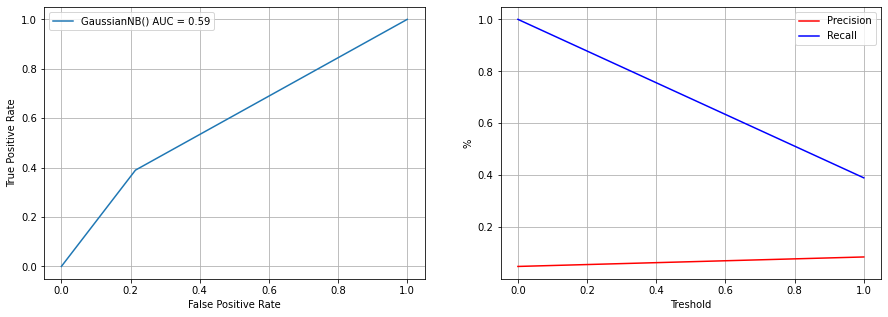

In [58]:
clf_logreg_gear_2, pred_logreg_gear_2 = logreg(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_rfc_gear_2, pred_rfc_gear_2 = rfc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gbc_gear_2, pred_gbc_gear_2 = gbc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_knn_gear_2, pred_knn_gear_2 = knn(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_abc_gear_2, pred_abc_gear_2 = abc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_svc_gear_2, pred_svc_gear_2 = svc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gnb_gear_2, pred_gnb_gear_2 = gnb(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)

## NOTE:

- From now on we will choose the final models. We could fine tune the models in very different ways like different period for rolling aggreggates, more rolling aggreggates (min, max, nº of outliers, etc), different model parameters, new models, different features, retrieve more data, etc
- Since this is a first project and we want to proceed to different stages, just for the purpose of learning, We will just define a threshold to decrease the number of the FP and calculate our costs savings
- We do not have a validation set to validate if the models generalize well
- Deploy into production